# Heat Flux Prediction

## Introduction

To predict the critical heat flux based on processed and compiled records of experimental critical heat flux and boundary conditions used. In this notebook an ensemble machine learning technique using optuna will used for the prediction of the heat flux. By optimizing the ensemble model, aim is to provide insights into the factors influencing heat flux.

In [36]:
# Data Handling
import pandas as pd
import numpy as np
import re

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning Models
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
from scipy.cluster.hierarchy import linkage, dendrogram

# Import Optuna
import optuna
from optuna.samplers import TPESampler

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import logging
# Set the log level for the optuna package to WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

## Load the Data

In [2]:
train_df = pd.read_csv('../artifacts/data.csv')
train_df.drop('id', axis = 1, inplace = True)
train_df.head()

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8


## Exploratory Data Analysis

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31644 entries, 0 to 31643
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   author               26620 non-null  object 
 1   geometry             26144 non-null  object 
 2   pressure [MPa]       27192 non-null  float64
 3   mass_flux [kg/m2-s]  26853 non-null  float64
 4   x_e_out [-]          21229 non-null  float64
 5   D_e [mm]             26156 non-null  float64
 6   D_h [mm]             27055 non-null  float64
 7   length [mm]          26885 non-null  float64
 8   chf_exp [MW/m2]      31644 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.2+ MB


In [4]:
desc = train_df.describe().T
desc['nunique'] = train_df.nunique()
desc['%unique'] = desc['nunique'] / len(train_df) * 100
desc['null'] = train_df.isna().sum()
desc

,count,mean,std,min,25%,50%,75%,max,nunique,%unique,null
pressure [MPa],27192.0,10.640747,4.333683,0.1000,6.8900,11.0700,13.7900,20.680,144,0.455063,4452
mass_flux [kg/m2-s],26853.0,3068.011023,1777.032080,0.0000,1519.0000,2731.0000,4069.0000,7975.000,733,2.316395,4791
x_e_out [-],21229.0,-0.000453,0.100911,-0.8667,-0.0466,0.0038,0.0648,0.232,1682,5.315384,10415
D_e [mm],26156.0,8.629255,5.185692,1.0000,5.0000,7.8000,10.8000,37.500,43,0.135887,5488
D_h [mm],27055.0,14.174330,19.838489,1.0000,5.6000,10.0000,11.5000,120.000,49,0.154848,4589
length [mm],26885.0,832.987391,672.299239,10.0000,318.0000,610.0000,914.0000,3048.000,70,0.221211,4759
chf_exp [MW/m2],31644.0,3.796985,1.983991,0.8000,2.4000,3.4000,4.6000,19.300,109,0.344457,0


**Insights:**
1. Except for `chf_exp [MW/m2]` all the columns including the target column `x_e_out [-]` has null values, would probably require some imputation strategy to be used.
2. `author` and `geometry` are 2 categorical input features.
3. All other features are numerical feature.

In [5]:
cat_features = train_df.select_dtypes(include = ['object']).columns.tolist()
num_features = train_df.select_dtypes(include = ['float64']).columns.tolist()

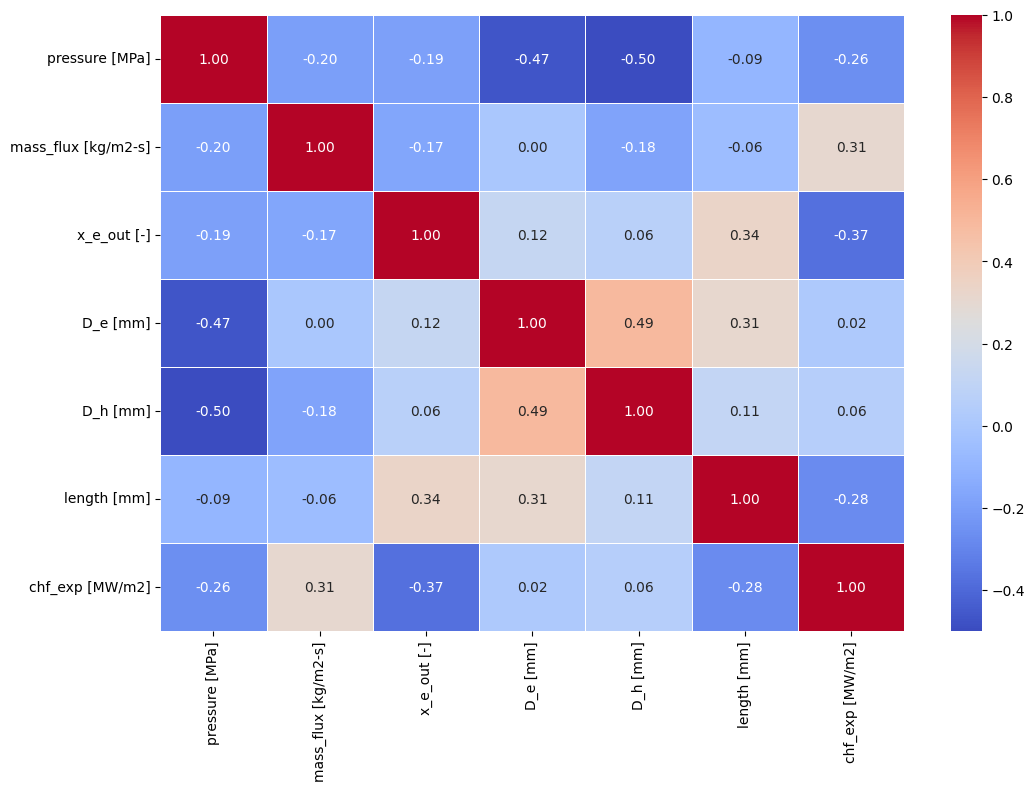

In [6]:
corr_matrix = train_df[num_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.show()

**Insights**:
1. There is positive correlation between `D_e [mm]` and `D_h [mm]` columns.
2. `pressure [MPa]` has a negative correlation with both `D_e [mm]` and `D_h [mm]` columns.

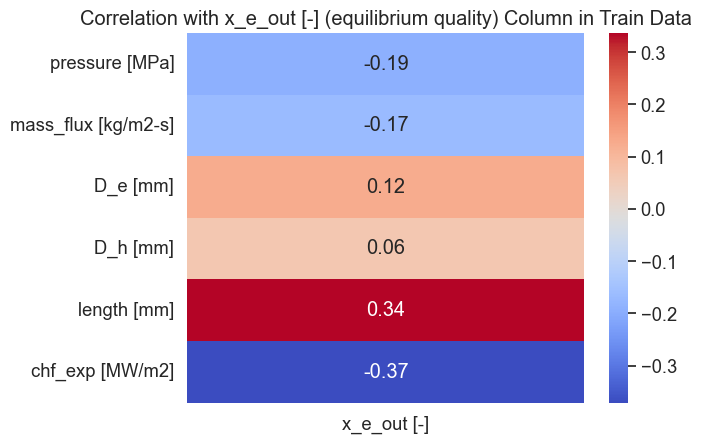

In [7]:
corr = train_df.drop(['author', 'geometry'], axis=1).corr()
target_corr = corr['x_e_out [-]'].drop('x_e_out [-]')

# Create a heatmap of the correlations with the target column
sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with x_e_out [-] (equilibrium quality) Column in Train Data')
plt.show()

**Insights**:
All the numerical columns aren't that highly correlated to the target column.

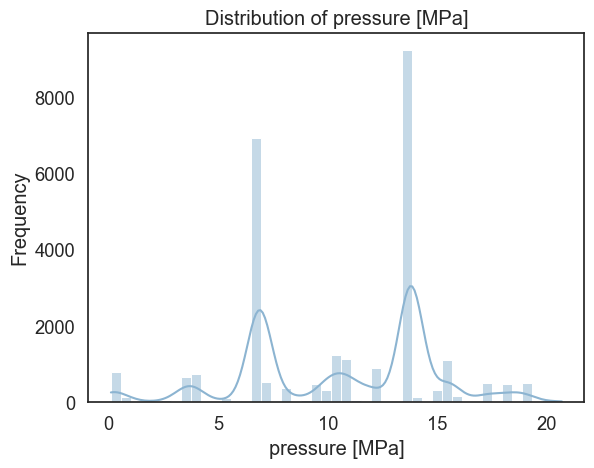

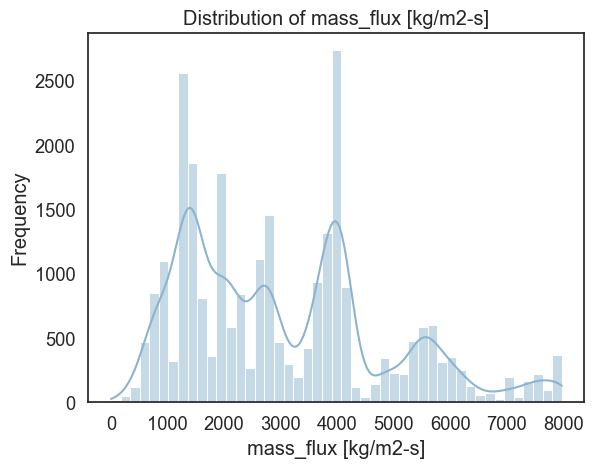

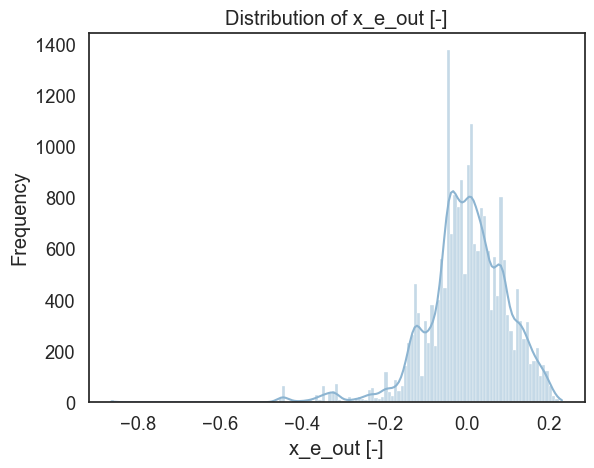

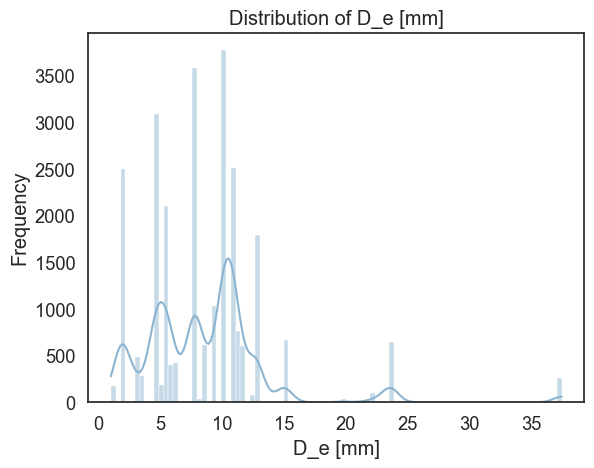

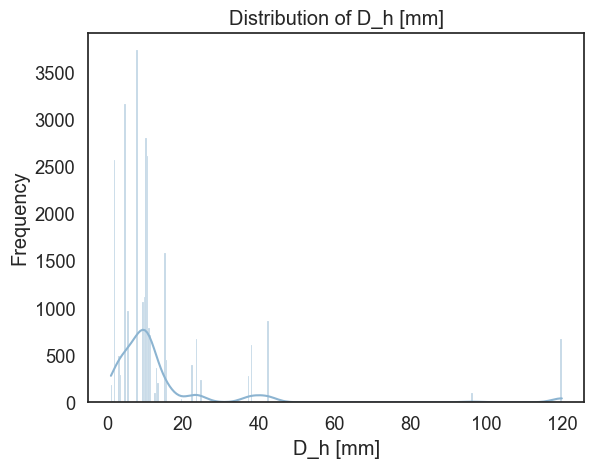

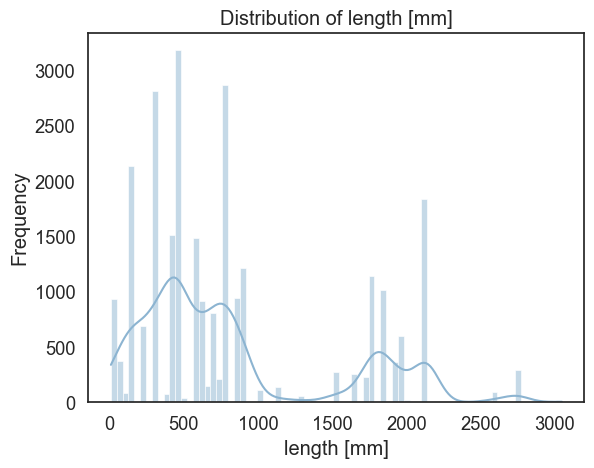

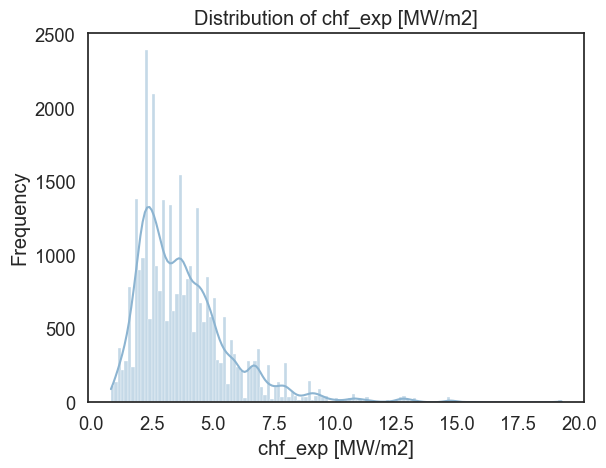

In [8]:
# Distribution of Numerical Features
for col in num_features:
        sns.histplot(train_df[col], kde=True)
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title('Distribution of {}'.format(col))
        plt.show()

**Insights**
1. Target Feature is having a normal distribution with an exception of few outliers which can be treated if required.

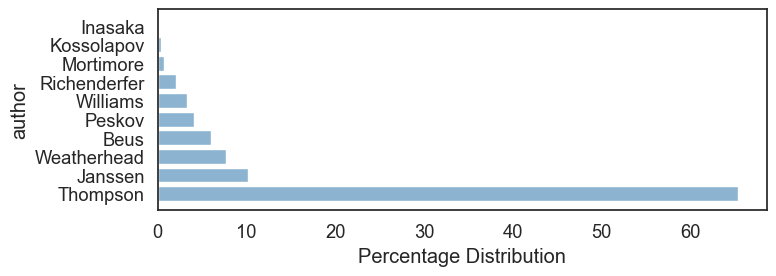

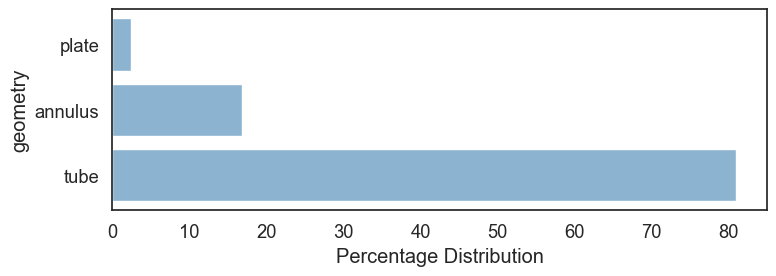

In [9]:
# Distribution of Categorical Features
for col in cat_features:
        value_counts = train_df[col].value_counts(normalize=True) * 100
        fig, ax = plt.subplots(figsize=(8, 3))
        ax.barh(value_counts.index, value_counts.values)
        ax.set_xlabel('Percentage Distribution')
        ax.set_ylabel(f'{col}')
        plt.tight_layout()
        plt.show()

**Insights**:
1. 'Thompson' seems to be the most frequent entry in `author` column
2. 'tube' seems to be the most frequent entry in `geometry` column.
3. These frequent entries can be used for imputation of missing categorical variables.

**Note:** All the missing values for the target variable are part of the test set.

In [10]:
train = train_df[train_df['x_e_out [-]'].isnull()!=True]
train.reset_index(inplace=True,drop=True)
test = train_df[train_df['x_e_out [-]'].isnull()==True]
test.reset_index(inplace=True,drop=True)

## Preprocessing

In [29]:

# Copy the original dataframe to avoid modifying the original data
processed_df = train.copy()

# Handling missing values in numerical variables
num_imputer = SimpleImputer(strategy='mean')
processed_df[num_features] = num_imputer.fit_transform(processed_df[num_features])

# Handling missing values in categorical variables
cat_imputer = SimpleImputer(strategy='most_frequent')
processed_df[cat_features] = cat_imputer.fit_transform(processed_df[cat_features]) 

# Label encoding for categorical variables
label_encoders = dict()

for col in cat_features:
    label_encoders[col] = LabelEncoder()
    processed_df[col] = label_encoders[col].fit_transform(processed_df[col].astype(str))

# Preprocess column names as some regressors in the ensemble can't handle column names not having alphanumeric or underscore
processed_df.columns = [re.sub(r'[\[\]<>\s]+', '_', col) for col in processed_df.columns]
processed_df.head()

,author,geometry,pressure_MPa_,mass_flux_kg/m2-s_,x_e_out_-_,D_e_mm_,D_h_mm_,length_mm_,chf_exp_MW/m2_
0,7,2,7.000000,3770.0,0.1754,8.589305,10.8,432.0,3.6
1,7,2,10.635066,6049.0,-0.0416,10.300000,10.3,762.0,6.2
2,7,2,13.790000,2034.0,0.0335,7.700000,7.7,457.0,2.5
3,0,0,13.790000,3679.0,-0.0279,5.600000,15.2,2134.0,3.0
4,7,2,17.240000,3648.0,-0.0711,8.589305,1.9,696.0,3.6


In [12]:
# Preprocess the data
X = processed_df.drop('x_e_out_-_', axis=1)
y = processed_df['x_e_out_-_']

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Hyperparameter Tuning

In [14]:
def lgbm_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    num_leaves = trial.suggest_int("num_leaves", 31, 127)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)

    model = LGBMRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        num_leaves=num_leaves,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

def catboost_objective(trial):
    iterations = trial.suggest_int("iterations", 100, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    depth = trial.suggest_int("depth", 3, 10)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 9)
    subsample = trial.suggest_float("subsample", 0.5, 1)

    model = CatBoostRegressor(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        subsample=subsample,
        random_state=42,
        verbose=0
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

In [15]:
# Run Optuna optimization for each model
sampler = TPESampler(seed=42)

# xgb_study = optuna.create_study(direction="maximize", sampler=sampler)
# xgb_study.optimize(xgb_objective, n_trials=50)

lgbm_study = optuna.create_study(direction="maximize", sampler=sampler)
lgbm_study.optimize(lgbm_objective, n_trials=50)

catboost_study = optuna.create_study(direction="maximize", sampler=sampler)
catboost_study.optimize(catboost_objective, n_trials=50)

# Print best hyperparameters for each model from Optuna
print("Best parameters for LightGBM from Optuna: ", lgbm_study.best_params)
print("Best parameters for CatBoost from Optuna: ", catboost_study.best_params)

Best parameters for LightGBM from Optuna:  {'n_estimators': 282, 'learning_rate': 0.1591834326646726, 'max_depth': 4, 'num_leaves': 80, 'subsample': 0.7962072844310213, 'colsample_bytree': 0.5232252063599989}
Best parameters for CatBoost from Optuna:  {'iterations': 420, 'learning_rate': 0.1028545558741516, 'depth': 5, 'l2_leaf_reg': 3, 'subsample': 0.6741756005025845}


## Ensemble Modelling

In [16]:
# Train multiple base models with the best parameters
# xgb = XGBRegressor(**xgb_best_params, random_state=42)
lgbm = LGBMRegressor(**lgbm_study.best_params, random_state=42)
catboost = CatBoostRegressor(**catboost_study.best_params, random_state=42, verbose=0)

In [17]:
# Feature selection using SelectKBest
selector = SelectKBest(score_func=f_regression, k=8)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [18]:
# Combine the base models to create an ensemble and assign weights
weights = [0.3, 0.3]
# Combine the base models to create an ensemble
ensemble = VotingRegressor([('lgbm', lgbm), ('catboost', catboost)])
# Train the ensemble model using selected features
ensemble.fit(X_train_selected, y_train)

VotingRegressor(estimators=[('lgbm',
                             LGBMRegressor(colsample_bytree=0.5232252063599989,
                                           learning_rate=0.1591834326646726,
                                           max_depth=4, n_estimators=282,
                                           num_leaves=80, random_state=42,
                                           subsample=0.7962072844310213)),
                            ('catboost',
                             <catboost.core.CatBoostRegressor object at 0x000002823BF5F910>)])

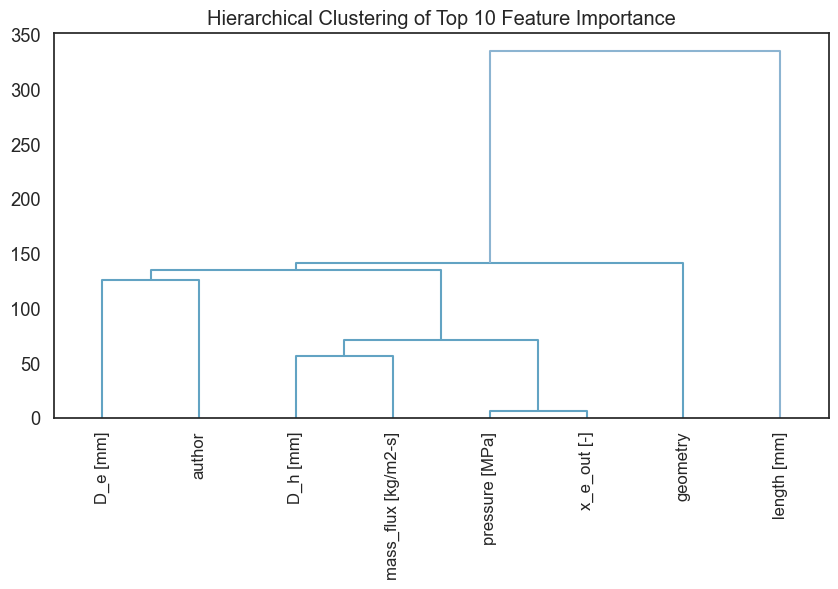

In [19]:
# Train the best performing LGBM model with the best hyperparameters from Optuna
best_lgbm = LGBMRegressor(**lgbm_study.best_params, random_state=42)
best_lgbm.fit(X_train, y_train)

# Get feature importance values
importances = best_lgbm.feature_importances_

# Number of top features to visualize
top_n = 10

# Sort the features by importance and select the top N
sorted_idx = np.argsort(importances)[-top_n:]
top_features = train_df.columns[:-1][sorted_idx].tolist()

# Perform hierarchical clustering on the top N features
linked = linkage(np.array(importances[sorted_idx]).reshape(-1, 1), 'single')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linked, labels=top_features, orientation='top', distance_sort='descending')
plt.title("Hierarchical Clustering of Top {} Feature Importance".format(top_n))
plt.xticks(rotation=90) 
plt.show()

## Model Evaluation

In [20]:
# Cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(ensemble, X_train_selected, y_train, cv=kfold, scoring='r2')
print("Cross-validation scores: ", cv_scores)
print("Mean CV R-squared: {:.2f}".format(np.mean(cv_scores)))
print("Standard Deviation of CV R-squared: {:.2f}".format(np.std(cv_scores)))

Cross-validation scores:  [0.45473402 0.46051014 0.46774311 0.46777858 0.4595542 ]
Mean CV R-squared: 0.46
Standard Deviation of CV R-squared: 0.01


In [21]:
# Make predictions using the selected features
y_pred = ensemble.predict(X_test_selected)

# Evaluate the performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: {:.2f}".format(mse))
print("R-squared: {:.2f}".format(r2))

Mean Squared Error: 0.01
R-squared: 0.46


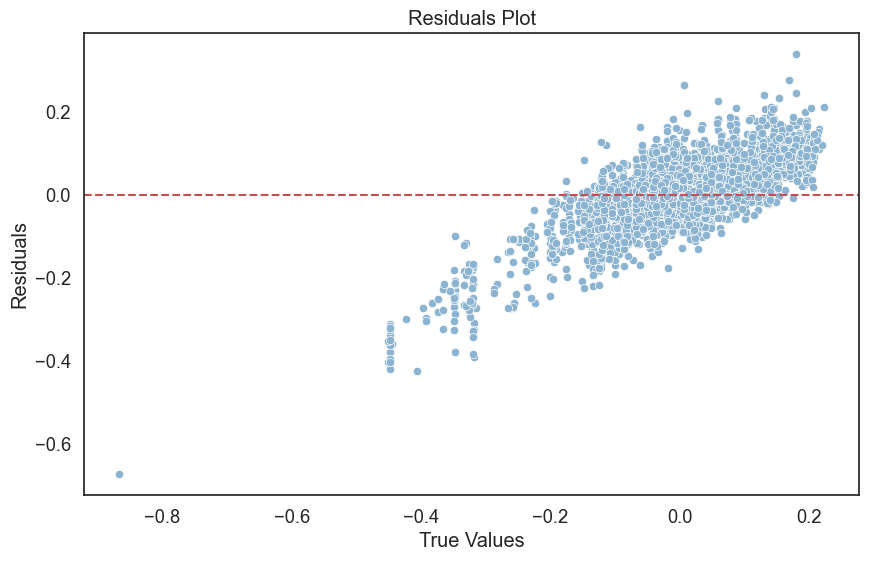

In [22]:
# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

## Model Prediction

In [23]:
num_features_test = test.drop('x_e_out [-]', axis=1).select_dtypes(include = ['float64']).columns.tolist()

In [30]:
# Copy the original dataframe to avoid modifying the original data
processed_test_df = test.copy()

# Handling missing values in numerical variables
processed_test_df[num_features] = num_imputer.transform(processed_test_df[num_features])

# Handling missing values in categorical variables
processed_test_df[cat_features] = cat_imputer.transform(processed_test_df[cat_features]) 

# Label encoding for categorical variables
for col in cat_features:
    processed_test_df[col] = label_encoders[col].transform(processed_test_df[col].astype(str))

# Preprocess column names as some regressors in the ensemble can't handle column names not having alphanumeric or underscore
processed_test_df.columns = [re.sub(r'[\[\]<>\s]+', '_', col) for col in processed_df.columns]
processed_test_df.head()

,author,geometry,pressure_MPa_,mass_flux_kg/m2-s_,x_e_out_-_,D_e_mm_,D_h_mm_,length_mm_,chf_exp_MW/m2_
0,7,2,13.790000,686.000000,-0.000453,11.100000,11.1,457.0,2.8
1,5,2,18.000000,750.000000,-0.000453,10.000000,10.0,1650.0,2.2
2,7,2,10.635066,3070.487779,-0.000453,1.900000,1.9,152.0,3.2
3,7,2,6.890000,7500.000000,-0.000453,8.589305,12.8,1930.0,4.8
4,0,0,15.510000,1355.000000,-0.000453,5.600000,15.2,2134.0,2.1


In [31]:
# Preprocess the data
test_X = processed_test_df.drop('x_e_out_-_', axis=1)

# Scale
X_test_scaled = scaler.transform(test_X)

# Apply feature selection
X_test_selected = selector.transform(X_test_scaled)

# Make predictions
y_test_pred = ensemble.predict(X_test_selected)
y_test_pred

array([ 0.00176371, -0.09187166, -0.06045561, ...,  0.03582928,
       -0.06209089, -0.00919615])

## Save Objects

In [34]:
import pickle
pickle.dump(scaler, open('../artifacts/notebook/scaling.pkl', 'wb'))
pickle.dump(ensemble, open('../artifacts/notebook/ensemble.pkl', 'wb'))
pickle.dump(selector, open('../artifacts/notebook/sel.pkl', 'wb'))
pickle.dump(label_encoders, open('../artifacts/notebook/les.pkl', 'wb'))